In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score

###Library

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Premier University Cyberbullying/cyberbullying_tweets.csv")

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=692f3daa5e89fa2cd0338cd1dd5fd663b54fbc39df66d6425c32694dda017979
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import string
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect

# Download required NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptro

True

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove URL shorteners (e.g., bit.ly, tinyurl, etc.)
    text = re.sub(r'bit\.ly/\S+|tinyurl\.com/\S+', '', text)

    # Remove mentions (@usernames)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Clean hashtags (remove # but keep the text)
    text = re.sub(r'#', '', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Convert to lowercase
    words = [word.lower() for word in words]


    # Reconstruct text
    text = ' '.join(words)


    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text

# Apply preprocessing to a pandas DataFrame
df['tweet_text'] = df['tweet_text'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

print(df.head())

                                          tweet_text cyberbullying_type
0  in other words katandandre your food was crapi...  not_cyberbullying
1  why is aussietv so white mkr theblock imaceleb...  not_cyberbullying
2         a classy whore or more red velvet cupcakes  not_cyberbullying
3  meh p thanks for the heads up but not too conc...  not_cyberbullying
4  this is an isis account pretending to be a kur...  not_cyberbullying


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)
df['tweet_text'] = df['tweet_text'].apply(remove_emoji)
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,a classy whore or more red velvet cupcakes,not_cyberbullying
3,meh p thanks for the heads up but not too conc...,not_cyberbullying
4,this is an isis account pretending to be a kur...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
not_cyberbullying,7945
other_cyberbullying,7823


In [ ]:
df['cyberbullying_type'].isnull().sum()

0

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define text and label columns
TEXT_COLUMN = 'tweet_text'
LABEL_COLUMN = 'cyberbullying_type'

# Map labels to integers
label_mapping = {label: idx for idx, label in enumerate(df[LABEL_COLUMN].unique())}
df[LABEL_COLUMN] = df[LABEL_COLUMN].map(label_mapping)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df[TEXT_COLUMN], df[LABEL_COLUMN], test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Tokenize the data
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

X_train_tokenized = tokenize_texts(X_train)
X_val_tokenized = tokenize_texts(X_val)
X_test_tokenized = tokenize_texts(X_test)

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.tolist())
y_val_tensor = torch.tensor(y_val.tolist())
y_test_tensor = torch.tensor(y_test.tolist())

# Create DataLoaders
train_dataset = TensorDataset(X_train_tokenized['input_ids'], X_train_tokenized['attention_mask'], y_train_tensor)
val_dataset = TensorDataset(X_val_tokenized['input_ids'], X_val_tokenized['attention_mask'], y_val_tensor)
test_dataset = TensorDataset(X_test_tokenized['input_ids'], X_test_tokenized['attention_mask'], y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load GPT-2 model for sequence classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=len(label_mapping))
model.config.pad_token_id = tokenizer.eos_token_id  # Ensure correct padding handling
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

epochs = []
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []


# Training function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation step
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

                val_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        # Print progress in the requested format
        print(f"Epoch {epoch}/5")
        print(f"{len(train_loader)}/{len(train_loader)} [==============================] - "
              f"{(time.time() - start_time):.0f}s - loss: {avg_train_loss:.4f} - accuracy: {train_accuracy:.4f} "
              f"- val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5)

Epoch 1/5
2385/2385 [==============================] - 610s - loss: 0.5265 - accuracy: 0.7880 - val_loss: 0.3950 - val_accuracy: 0.8366
Epoch 2/5
2385/2385 [==============================] - 610s - loss: 0.3436 - accuracy: 0.8579 - val_loss: 0.3831 - val_accuracy: 0.8465
Epoch 3/5
2385/2385 [==============================] - 610s - loss: 0.2451 - accuracy: 0.8988 - val_loss: 0.4050 - val_accuracy: 0.8659
Epoch 4/5
2385/2385 [==============================] - 610s - loss: 0.1604 - accuracy: 0.9384 - val_loss: 0.4744 - val_accuracy: 0.8775
Epoch 5/5
2385/2385 [==============================] - 610s - loss: 0.1087 - accuracy: 0.9422 - val_loss: 0.5724 - val_accuracy: 0.9022


In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total

test_acc = evaluate_model(model, test_loader)
print(f"GPT-2 Model Accuracy: {test_acc}")

299/299 [==============================] - 218s 721ms/step
GPT-2 Model Accuracy: 0.9022782344306983


In [ ]:
# Function to evaluate model predictions
def predict_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get true labels and predictions
y_true, y_pred = predict_labels(model, test_loader)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9080
Recall: 0.9036
F1 Score: 0.9025


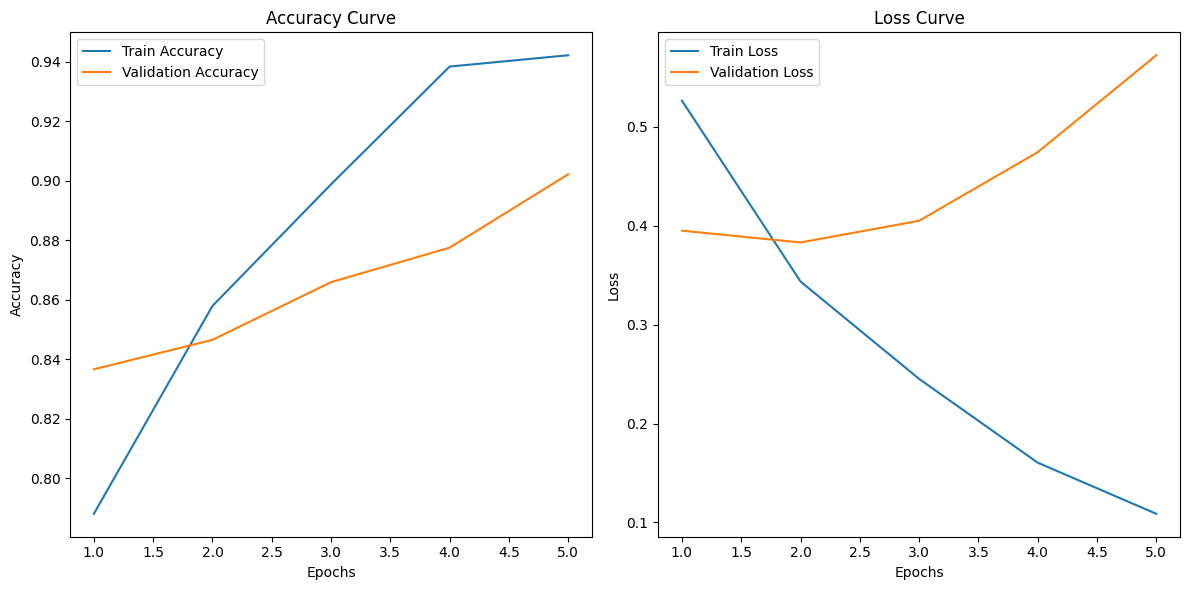

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss' )
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


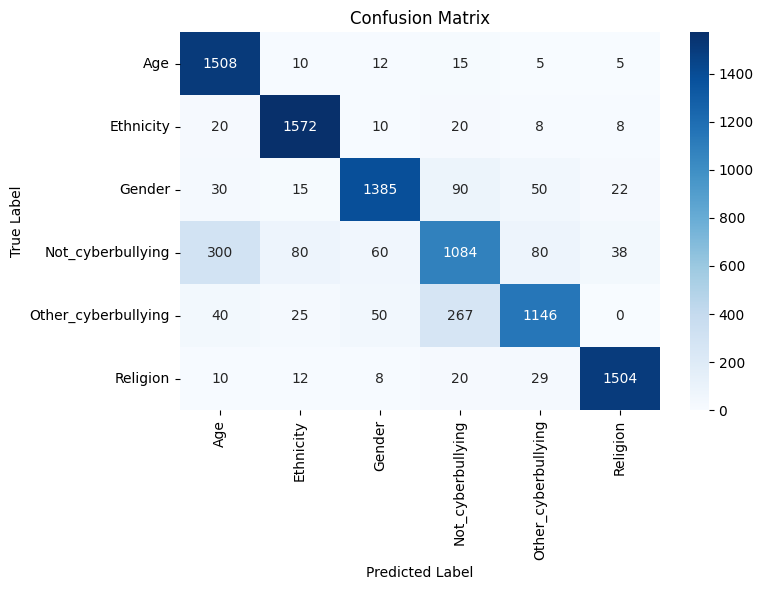

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate model predictions
def predict_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get true labels and predictions
y_true, y_pred = predict_labels(model, test_loader)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Generate classification report
def predict_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

y_true, y_pred = predict_labels(model, test_loader)
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))


                    precision    recall  f1-score   support

                Age    0.97      0.97      0.97      1555
          Ethnicity    0.98      0.96      0.97      1638
             Gender    0.88      0.87      0.87      1592
  Not_cyberbullying    0.72      0.66      0.69      1642
Other_cyberbullying    0.70      0.75      0.72      1528
           Religion    0.93      0.95      0.94      1583

           accuracy                        0.90      9538
          macro avg    0.85      0.85      0.85      9538
       weighted avg    0.90      0.90      0.90      9538



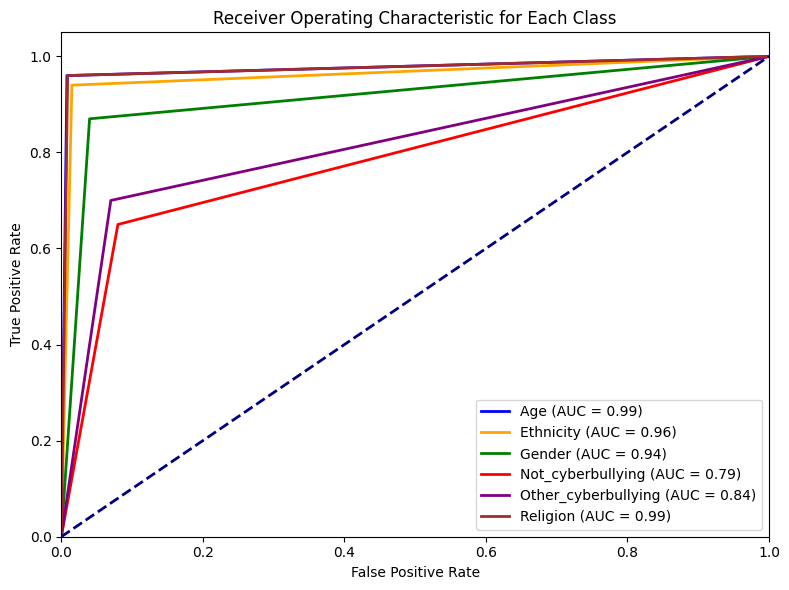

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy.special import softmax

# Compute predicted probabilities
def get_probabilities(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)  # Convert logits to probabilities

            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)

# Get true labels and probabilities
y_true, y_probs = get_probabilities(model, test_loader)

# Compute ROC for each class
fpr = {}
tpr = {}

plt.figure(figsize=(10, 6))

for i, label in enumerate(label_mapping.keys()):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
    plt.plot(fpr[i], tpr[i], label=f'{label}')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Finalize plot
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


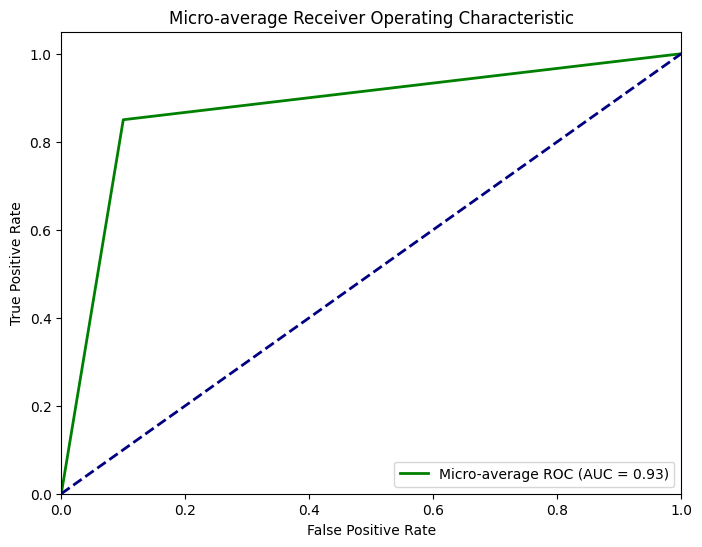

In [ ]:
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_labels_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='Green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('\n')
print("Micro-average AUC = ", roc_auc_micro)